## 9-1. Classical Error
Data storage methods can be categorized as volatile, which is initialized over time, or nonvolatile, which, in principle, is virtually non-degradable. Here we consider the memory cells of a DRAM, a type of volatile memory.
Modern calculators express binary information of 0,1 in terms of analog continuous quantities of electrons stored in capacitors. (In telecommunications, it is expressed in terms of the number of photons in a certain frequency band or time interval.) Here, the state in which energy is stored is 1, and the state in which energy is completely released is 0.

These analog quantities are not always at a constant value due to external interactions. Electrons are released at a certain rate over time, e.g., due to leakage currents in transistors.
Thus, a state of 1 will change to a state of 0 after a while. This change occurs on a non-negligible scale of approximately less than a second in modern devices.
This is "an error that occurs at a constant rate due to changes in time, regardless of the presence or absence of an operation".
In classical devices, such errors are corrected by "reading the amount of remaining electrons at regular intervals and recharging the battery according to that number, well before 0 and 1 become undeterminable".
This operation is called refreshing, and is performed periodically even if the user does not intend it. Naturally, when the power is turned off, the refresh is no longer performed. This is why DRAM is called volatile memory.
When refresh is performed and leakage effects are negligible, the next important error factor is transistor malfunction due to neutron radiation.
Neutron rays are a type of cosmic ray and are difficult to protect against because they can penetrate metals and other materials. When these neutron rays pass through a transistor, the electric charge generated can cause the transistor to malfunction.
Therefore, a neutron beam error is "an error triggered by some operation that occurs uniquely".
If the transistor operates and the gate is released when it is not the read timing, the state of the capacitor changes according to the state of the bit line, which is unintended.
The probability of a bit being inverted due to this error is small enough to be negligible to the average user, but for very large calculations, it cannot be ignored.
If the probability of a neutron line colliding and malfunctioning in unit time per unit bit is $p$, then the probability that an $n$-bit memory does not change a single bit for $t$ seconds is
$q = (1-p)^{nt}$. Assuming $n=10^{12}, t=10^{3}$ and $q=0.99$, the probability must be $p\sim 10^{-18}$.

The major difference between a neutron beam error and a leak is that while a leak can be restored if checked immediately, it is impossible to know what state the neutron beam was originally in after it occurs.
For this reason, ECC (Error-correcting code) memory with error correction is used in applications where neutron beam errors are a problem, and ECC memory corrects errors up to 1 bit with a small overhead.

### Classical error correction: majority rule
The simplest code is majority voting. In majority rule, individual bits are copied $d$ times. In this case, $k$ bits of information are represented by $n:=dk$ bits. To prevent a majority vote tie, $d$ is assumed to be an odd number.
The $n$ bits that exist in reality are called physical bits, and the $k$ bits that are represented as reality are called logical bits.

Majority voting detects and corrects errors as follows. For each logical bit, the information on the duplicated $d$ bits is read, and the number of 0s or 1s that are counted. The value with the highest frequency is then determined to have been the value of that logical bit. Whatever the initial value, the encoded state is the same for all values, so if the values of the $d$ bits do not match even one, we can be sure that some error has occurred. Therefore, unless $n$ bits are inverted in their entirety, an error can always be detected.

If we want to correct the error, we can obtain the correct result if more than half of the bits retain their correct values. Assuming that each bit has a probability $p$ of error that is sufficiently smaller than 1, the probability that more than half of the bits have an error is approximately $p^{\lfloor d/2 \rfloor+1}$.
Thus, we see that for each $2 increase in $d$, the probability of a majority vote failing is $p$ times smaller in order.
The code to simulate the simplest case of $k=1$ can be written as follows.

In [1]:
import numpy as np

data = 1
d = 31
p = 0.01

print("original bit: {}".format(data))
state = np.repeat(data, d)
is_flipped = (np.random.rand(d)<p).astype(np.int)
state = (state + is_flipped)%2
if np.sum(state==0) < np.sum(state==1):
    majority = 1
else:
    majority = 0
        
print("decoded bit: {}".format(majority))

original bit: 1
decoded bit: 1


The above will randomly vary in success or failure, but the probability of success can be known as the cumulative binomial distribution with respect to probability $p$.
Plotting the horizontal axis as the error probability of each bit and the vertical axis as the success probability of decoding for various odd numbers of $d$, we obtain the following.

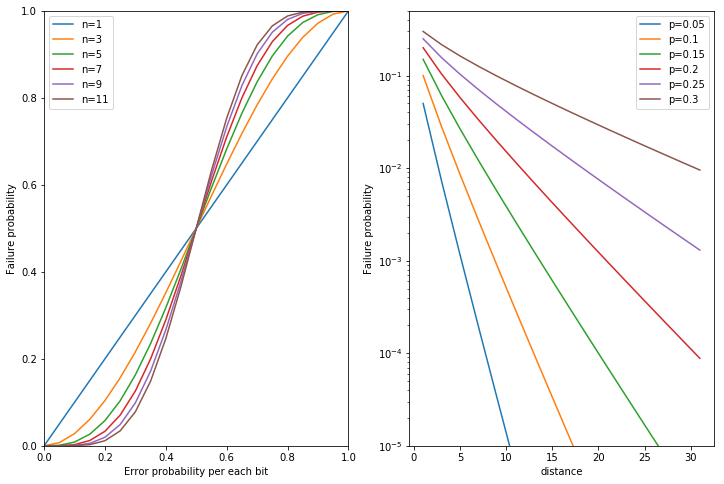

In [3]:
import numpy as np

d = 31
fail_prob_list = []
p_list = np.linspace(0,1,21)
for p in p_list:
    fail_prob = []
    binomial = [1]
    for m in np.arange(2,d+2):
        nbin = np.zeros(m)
        for i in range(m):
            if i!=0:
                nbin[i] += binomial[i-1]*p
            if i+1<m:
                nbin[i] += binomial[i]*(1-p)
        binomial = nbin
        if m%2==0:
            fail = np.sum(binomial[m//2:])
            fail_prob.append(fail)
    fail_prob_list.append(fail_prob)
fail_prob_list = np.array(fail_prob_list).T

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
for index,line in enumerate(fail_prob_list[:6]):
    plt.plot(p_list, line, label = "n={}".format(2*index+1))
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel("Error probability per each bit")
plt.ylabel("Failure probability")
plt.legend()

plt.subplot(1,2,2)
for index,line in enumerate(fail_prob_list.T[:7]):
    if index==0:
        continue
    distance_list = np.arange((d+1)//2)*2+1
    plt.plot(distance_list,line, label = "p={:.3}".format(p_list[index]))
plt.ylim(1e-5,0.5)
plt.yscale("log")
plt.xlabel("distance")
plt.ylabel("Failure probability")
plt.legend()
plt.show()

The left graph shows that if $p$ is below a certain value (0.5 in this case), the performance improves as $d$ is increased.
On the other hand, if $p$ is above a certain value, increasing $d$ does not improve the performance, but rather worsens it.
This indicates that, in order to perform error correction by majority voting, it is necessary for each device to have at least an error rate below a certain level.

This behavior is often observed in scaling codes, including quantum codes, and this threshold error probability is called the error threshold. Classical error correction in general is performed at a value much smaller than the error threshold, but quantum error correction is often mentioned because the current errors are around the threshold.

The graph on the right shows an exponential plot of how much the probability of decoding failure decreases when $p$ is fixed at a constant value below the threshold and $d$ is increased. When $p$ is sufficiently smaller than the threshold value, the probability of decryption failure generally decreases exponentially as $d$ is increased.

### Linear Codes
The above majority voting framework is a type of code called a linear code. In the following, majority voting is explained in the framework of linear codes.
The operation of making some $k$ bits of information $v$ redundant to $n=dk$ bits of information $v'$ can be paraphrased as constructing a $k \times n$ matrix $G$ as follows and computing $v' = vG$.
(See also `10.4.1 Classical linear codes` in Nielsen-Chuang.)

In [5]:
import numpy as np
k = 4
m = 3
n = k*m
v = np.random.randint(2,size=k)
print("original vector: v\n{}".format(v))

G = np.zeros((k,n),dtype=np.int)
for y in range(k):
    G[y,y*m:(y+1)*m]=1
print("generator matrix: G\n{}".format(G))

vd = (v@G)%2
print("encoded vector: v' = vG\n{}".format(vd))

original vector: v
[0 1 0 1]
generator matrix: G
[[1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1]]
encoded vector: v' = vG
[0 0 0 1 1 1 0 0 0 1 1 1]


This matrix $G$ is called the generator matrix.

Of the $2^n$ patterns of $n$ bit sequences to be generated, at most $2^k$ $n$ bit sequences created in the form of $vG$ are called code words. When the set of code words is $W$, the minimum Hamming distance between two code words that are $w \neq w'$ is called the distance of the code (distance). In the current majority rule configuration, the distance of a code is the number $d$ , how many times individual logical bits to be replicated. If a number of bits greater than the distance $d$ are inverted all at once, they change from one code word to another. Therefore, it becomes difficult to distinguish whether the current code was generated correctly or whether the error occurred on another code. This shows that the condition under which an error can be detected is that the number of bits where the error occurs is less than the distance $d$.

Next, consider an $n \times (n-k)$ matrix $H_c$ such that $GH_c = 0$ under mod 2 and each row vector is independent. In this case, the following $H_c$ that looks at two adjacent parities every 3 bits satisfies the conditions.

In [6]:
Hc = np.zeros((n,n-k),dtype=np.int)
for x in range(n-k):
    Hc[x//2*m+x%2:x//2*m+x%2+2,x]=1
print("check matrix: H\n{}".format(Hc))

print("G Hc = \n{}".format( (G@Hc)%2))

check matrix: H
[[1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1]]
G Hc = 
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


Since the column vectors of $H_c$ are independent, there are $2^n / 2^{n-k} = 2^k$ patterns out of $n$ bit strings $w$ of $2^n$ patterns that satisfy $w H_c = 0$. Also, the code word $w$ belonging to the set $W$ of code words is $w H_c = v G H_c = 0$. Therefore, the set $W$ of code words can be said to be the set of bit strings satisfying $w H_c = 0$. At the same time $n$ bit strings $w$ are not code words $(w \neq W)$, if $w H_c \neq 0$. If $w \in W$, and if the vector $s = w H_c$ is $0$ only when $w \in W$, the vector $s = w H_c$ is called the **syndrome** of $w$

In summary, the set of code words $W$ can be characterized by any of the two matrices $G,H_c$ and

\begin{align}
W &= \left\{w \in \{0,1\}^n \mathrel{}\middle|\mathrel{} \exists v \in \{0,1\}^k , w = vG \right\} \\
W &= \left\{w \in \{0,1\}^n \mathrel{}\middle|\mathrel{} w H_c = 0 \right\}
\end{align}

If an error $e$ occurs after encoding, the state of the code after the error is $v'+e$.
At this time, the error can be detected by checking whether the syndrome value $s = (v'+e)H_c$ of $v'+e$ is all 0.
If even one of the syndrome values is not 0, some error has occurred. If the syndrome values are all 0, either no error has occurred or an undetectable $d$-bit or greater error has occurred.

In [7]:
p = 0.05
print("encoded vector: v'\n{}".format(vd))
e = np.random.choice([0,1],size=len(vd),p = [1-p,p])
print("error vector: e\n{}".format(e))
vde = (vd+e)%2
print("encoded vector with noise: v'+e\n{}".format(vde))
s = (vde@Hc)%2
print("syndrome values: s = (v'+e)Hc\n{}".format(s))

encoded vector: v'
[0 0 0 1 1 1 0 0 0 1 1 1]
error vector: e
[0 0 0 0 0 0 0 0 0 0 0 0]
encoded vector with noise: v'+e
[0 0 0 1 1 1 0 0 0 1 1 1]
syndrome values: s = (v'+e)Hc
[0 0 0 0 0 0 0 0]


Because $GH_c=0$, $s =(v'+e)H_c = vGH_c + eH_c = eH_c$. This means that the syndrome value is independent of the initial state vector $v$.

In making an $n$-bit majority decision, we can look at $v'+e$ from left to right, $m$ by $m$, and make a majority decision.

In [8]:
p = 0.1
print("encoded vector: v'\n{}".format(vd))
e = np.random.choice([0,1],size=len(vd),p = [1-p,p])
print("error vector: e\n{}".format(e))
vde = (vd+e)%2
print("encoded vector with noise: v'+e\n{}".format(vde))
s = (vde@Hc)%2
print("syndrome values: s = (v'+e)Hc\n{}".format(s))
def decode(vde,k,m):
    for x in range(k):
        subset = vde[x*m:(x+1)*m]
        val = np.argmax(np.bincount(subset))
        vde[x*m:(x+1)*m] = val
    return vde
vde_recovery = decode(vde,k,m)
print("recovered vector: \n{}".format(vde_recovery))

encoded vector: v'
[0 0 0 1 1 1 0 0 0 1 1 1]
error vector: e
[0 0 0 0 0 0 0 0 0 0 0 1]
encoded vector with noise: v'+e
[0 0 0 1 1 1 0 0 0 1 1 0]
syndrome values: s = (v'+e)Hc
[0 0 0 0 0 0 0 1]
recovered vector: 
[0 0 0 1 1 1 0 0 0 1 1 1]


The decoding above can fail as the error is increased, and more than half of the $M$ is wrong.

If a vector $e$ that is not $0$ with $e H_c=0$ is generated, such an error cannot be corrected. In other words, when the parity check matrix is $H_c$, the distance $d$ of the sign is 

$$
d := \min w(e) \, \text{s.t.} \, H_e e = 0
$$

$w(x)$ is the weight of the bitstring $x$, i.e., the Hamming distance to $0\cdots0$)

### Horizontal and Vertical Parity Check Codes
In real-world error correction, the majority voting method is not used very often due to its poor performance. In this section, we will study the framework of horizontal and vertical parity checking codes as an example of parity checking codes often used in real-world error correction.

Parity is the remainder of the sum of a given number of bits divided by two, i.e., whether the number of 1's is even or odd. The parity of (1,1,1) is 1 and the parity of (0,1,1) is 0.
Parity checking codes enable error detection and correction by retaining some parity about the data of the original information.
If an error occurs in the original information or parity, the error can be detected because the parity values are no longer consistent with the original information.

The simplest parity checking code is the checksum. When using checksum, for each small block $(x_1,\ldots, x_b)$, the parity $p= \sum_i x_i \bmod 2$ of the bit sequence contained in the block is recorded as a checksum.
If the bits in the block or the checksum bits are incorrectly recorded  by 1 bit during transmission, the parity of the bit sequence contained in the block will be inconsistent with the parity $p$ to be retained if the parity is recalculated.
Thus, we know that a bit error occurred somewhere in the block or parity. However, this method cannot tell where the error occurred, nor can it detect an error if a 2-bit error occurred.

In [9]:
import numpy as np
length = 16
p = 0.05

# set random bitarray
bitstring = np.random.randint(2,size = length)
checksum = np.sum(bitstring)%2
print("original bitarray: {}". format(bitstring))
print("checksum: {}".format(checksum))

# error occurs
error = np.random.choice([0,1], size = length, p = [1-p, p])
print("error:             {}". format(error))

bitstring = (bitstring + error)%2
print("noisy bitarray:    {}". format(bitstring))
new_checksum = np.sum(bitstring)%2
print("checksum: {}".format(new_checksum))

# verify checksum
if checksum == new_checksum:
    print("No error detected")
else:
    print("Error detected!")

original bitarray: [0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0]
checksum: 1
error:             [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
noisy bitarray:    [0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1]
checksum: 0
Error detected!


In order to correct as well as detect a single bit error, it must be possible to tell where the error occurred.
A naive method to achieve this is a technique called horizontal and vertical parity checking.
The target to be protected is a vector of $k=16$ bits, which is placed in a $4*4$ matrix.
Here, we use $8$ bits of parity for row vector and column vector.
In this case, if an error occurs in $k$ bits, the parities of one column and row will not match. In this case, the data bits matching the unaligned column and row are determined to be inverted.
If an error occurs in the row parity bits, the column parities should all match. Thus, if only one parity has an error, we conclude that the parity has been inverted. The same is true for errors in the columns.
This way, if a bit error occurs at any location, we can determine the cause if it is a single bit. The distance of this code is 3 bits and $[n,k,d] = [24,16,3]$. In general, $[w^2+2w,w^2,3]$. (where $[n,k,d]$ is a triplet of numbers that characterize the code, where $n$ is the number of bits used, $k$ is the number of bits that can be encoded, and $d$ is the distance of the code)

In [10]:
import numpy as np
width = 4
height = 4
size = width*height
p = 0.03

def show(bitmatrix, vertical_parity, horizontal_parity):
    for y in range(height):
        print("{} | {}".format(bitmatrix[y,:], horizontal_parity[y] ))
    print("-"*width*2)
    print("{}".format(vertical_parity ))
    print()

# set random bitarray
bitstring = np.random.randint(2,size=size)
print("original bitarray: {}". format(bitstring))

# check horizontal and vertical parity
bitmatrix = bitstring.reshape( (height,width) )
vertical_parity = np.sum(bitmatrix, axis = 0)%2
horizontal_parity = np.sum(bitmatrix, axis = 1)%2
print("stored as : ")
show(bitmatrix,vertical_parity, horizontal_parity)

# error occurs
encoded_size = size + width + height
error = np.random.choice([0,1], size = encoded_size, p = [1-p, p])
bitmatrix = (bitmatrix + error[:size].reshape((height,width)))%2
vertical_parity = (vertical_parity + error[size:size+width])%2
horziontal_parity = (vertical_parity + error[size+width:])%2

# result
print("result is : ")
show(bitmatrix,vertical_parity, horizontal_parity)

# verify checksum
result_vertical_parity = np.sum(bitmatrix, axis = 0)%2
result_horizontal_parity = np.sum(bitmatrix, axis = 1)%2
vertical_flip_count = np.sum((result_vertical_parity + vertical_parity)%2)
horizontal_flip_count = np.sum((result_horizontal_parity + horizontal_parity)%2)

if vertical_flip_count == 0 and horizontal_flip_count == 0:
    print("No error detected")
    print("decoded bitarray: ")
    show(bitmatrix, result_vertical_parity, result_horizontal_parity)
elif vertical_flip_count == 1 and horizontal_flip_count == 0:
    print("Error occurs on vertical parity")
    print("decoded bitarray: ")
    show(bitmatrix, result_vertical_parity, result_horizontal_parity)
elif vertical_flip_count == 0 and horizontal_flip_count == 1:
    print("Error occurs on horizontal parity")
    print("decoded bitarray: ")
    show(bitmatrix, result_vertical_parity, result_horizontal_parity)
elif vertical_flip_count == 1 and horizontal_flip_count == 1:
    print("Error occurs on data bit")
    print("decoded bitarray: ")
    x = np.argmax((result_vertical_parity + vertical_parity)%2)
    y = np.argmax((result_horizontal_parity + horizontal_parity)%2)
    bitmatrix[y,x] = (bitmatrix[y,x]+1)%2
    show(bitmatrix, vertical_parity, horizontal_parity)
else:
    print("Too many error occurs")

original bitarray: [1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0]
stored as : 
[1 0 0 1] | 0
[0 0 0 1] | 1
[0 0 1 1] | 0
[1 0 0 0] | 1
--------
[0 0 1 1]

result is : 
[1 1 0 1] | 0
[0 0 0 1] | 1
[0 1 1 1] | 0
[1 0 0 0] | 1
--------
[0 0 1 1]

Too many error occurs


Similar to majority vote, a generator matrix and an parity check matrix can be considered for horizontal and vertical parity checking codes.
For simplicity, consider the case of horizontal and vertical parity checking for 6 ($2 \times 3$ )bits.
Let $v$ be the horizontal vector of bits to be encoded by horizontal and vertical parity checking. The calculation to observe the $(1,2,3)$-th parity is equivalent to preparing a vector $w = (1,1,1,0,0,0,0)$ where only the $1,2,3$-th is 1 and the others are 0 and calculating the inner product between the vectors $v w^{\rm T} \bmod 2$. Thus, the parity bits added to the original data can be generated by applying the matrix $A$ under mod 2 as follows. Note that mod 2 is omitted in subsequent operations between binary bits unless otherwise noted.

In [11]:
A = np.array([
    [1 , 0 , 1 , 0 , 0],
    [1 , 0 , 0 , 1 , 0],
    [1 , 0 , 0 , 0 , 1],
    [0 , 1 , 1 , 0 , 0],
    [0 , 1 , 0 , 1 , 0],
    [0 , 1 , 0 , 0 , 1]
])
print(A)

[[1 0 1 0 0]
 [1 0 0 1 0]
 [1 0 0 0 1]
 [0 1 1 0 0]
 [0 1 0 1 0]
 [0 1 0 0 1]]


At this time, the vector $p$ of parity values is $p = vA$, and the binary vector after encoding is $v' = (v, p)$. Therefore, if we put the $k \times n$ matrix $G = (I, A)$ as the generating matrix, then $v' = v G$.

The encoded binary vector has an error $e$. Let $e_v$ be the error in the data part of $e$ and $e_p$ be the error in the parity part. The binary vector after the error is $v'+e = (v+e_v, p+e_p)$. Horizontal and vertical parity checking determines whether an error has occurred, based on whether the parity values match after the error has occurred.

$$
(v + e_v)A = p + e_p
$$

whether this holds or not is equal to whether an error is detected.

Reorganizing the above formula using $p=vA$, the condition under which no error is detected is 

$$
e_v A + e_p = (e_v, e_p) \left(\begin{matrix} A \\ I \end{matrix}\right) = 0
$$

Putting the matrix $H_c$ as $H_c = \left( \begin{matrix} A \\ I \end{matrix} \right)$, we have

$$
G H_c = (I, A) \left(\begin{matrix} A \\ I \end{matrix}\right) = A + A = 0
$$

In [12]:
G = np.hstack( (np.eye(A.shape[0]), A) )
Hc = np.vstack( (A, np.eye(A.shape[1])) )
print("generator matrix: G\n{}\n".format(G))
print("check matrix: Hc \n{}\n".format(Hc))
print("GHc = \n{}\n".format( (G@Hc)%2 ))

generator matrix: G
[[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.]]

check matrix: Hc 
[[1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

GHc = 
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]



Numerically, we can see that $GH_c = 0$ indeed. Since $H_c$ is an $n \times (n-k)$ matrix and the column vectors have submatrices of the identity matrix, they are clearly independent column by column and certainly satisfy the property of parity check matrix.

In this case, the syndrome value $s$ is $s = e H_c$. When all the syndrome values are 0, the sign determines that no error has occurred. Of course, if a large error has occurred, $s=0$ and the sign is determined to be error-free even though an error has occurred.

If $s \neq 0$, we know that some error has occurred. To correct the error in this situation, we have to guess $v$ from the value of $(v'+e)$. In this case, if there is up to one error, we can identify where the error is with $O(1)$ by the method shown in the code at the beginning.

The framework of a parity check code can be summarized as follows.

- Codes: characterized by the generator matrix $G$ and the parity check matrix $H_c$. They satisfy $GH_c = 0$.
- Before coding: $k$-bit transversal vector data $V$.
- Encoding: Using the generating matrix $G$ of $k \times n$, the encoded state $v'$ is $v'=vG$.
- Error: $n$-bit sequence $e$ is randomly added to $v'$ .
- Error checking: $n \times (n-k)$ parity check matrix $H_c$ is used to obtain the syndrome $s = e H_c$. If $s \neq 0$, an error can be detected. If $s=0$, either no error has occurred or the error is above the limit that can be checked.
- Error correction: Guess $k$-bit transverse vector data $v$ according to the value of $(v'+e)$. The algorithm to find $v$ from $v'+e$ is called the decoding algorithm.
- Distance: The minimum weight of $e$ such that $e H_c = 0$ is the distance $d$ of the code.

Parity checking code is a very broad framework. For example, a type of parity checking matrix called a Hamming code is used in ECC memory.

### The Case of General Linear Codes

In the above, we have given specific examples of majority rule, checksum, and horizontal and vertical parity check, but in actual use, we want the best-performing code for our purposes. However, in general, finding the optimal linear code $G,H_c$ for a given $(n,k,d)$ is a combinatorial problem and is generally difficult.

Moreover, even if the optimal code $(G,H_c)$ is given, there are problems with decoding. An example of a naive decoding algorithm is minimum distance decoding.
That is, when observing the syndrome $s$, consider $e'$ that satisfies $s = e'H_c$ and causes an error in the least number of bits. Consider this as the error that occurred. We then attempt to recover $(v' + e + e')$ expecting it to be the correct code word.
The above optimization is the following $n$-bit 0,1 programming problem.

$$
\min_{e \in \{0,1\}^n} w(e') \, \text{s.t.} \, s = e' H_c 
$$

Minimum distance decoding is generally NP-hard for the size of the code. Moreover, this decoding is not always consistent with optimal decoding in practice. On the other hand, if the type of codes and errors that occur are limited, minimum-distance decoding can be performed efficiently, and in many cases this decoding method is close to optimal decoding. For example, majority voting always allows minimum-distance decoding, and horizontal and vertical parity check codes allow minimum-distance decoding with $O(1)$ if the errors that occur are limited to $w(e)=1$.

### Operations on linear codes
When information is passed through noisy communication paths, information encoded with parity check codes should be transferred. However, if the computer itself is noisy, computation must be performed with the information encoded with a parity check code. For example, if the CPU itself is noisy and wants to perform calculations in the encoded state, there is no point in encoding if it has to be decoded for each calculation.

When using the horizontal and vertical parity checking described above, if we perform a bit-flip operation on the $(i,j)$ elements of a matrix, the associated parity values must also be updated to prevent this operation from being detected as an error. In other words, to update $1$ bits, a $3$ bit operation is required on the encoded bit sequence.

Considering the cost of the operation, the fewer the number of bits that must actually be manipulated when manipulating a logical bit, the better.
The number of bits that must actually be inverted to invert a logical bit is at most $\max_i w(G_i)$.  $G_i$ is the $i$-row vector of $G$. At the horizontal and vertical parity check, all $G$ rows have weight of 3.

### Low-density parity check codes
When the time available for communication is limited, such as communication with outer space, or when the communication channel must be poor, we want to send a large amount of data at a rate as close to the limit as possible. This motivates us to create codes with the lowest logical error rate per bit to be encoded, even if the computational cost of encoding and decoding can be large.

If the noise in the communication channel is known, the rate limit of the amount of information that can be transmitted over a noisy communication channel can be calculated as the Shannon limit. This rate implies the performance limit of the code that can be constructed. Low-density parity checking codes are codes that achieve performance close to the Shannon limit.

Low-density parity checking code is a generic term for parity checking codes in which the $H_c$ checking matrix is a sparse matrix. A sparse matrix here means that the number of $1$ in each column is at most $O(k)$. This means that each syndrome value can be represented by a parity of $O(k)$ bits of errors.

The advantage of low-density parity checking codes is that their performance is close to the Shannon limit. On the other hand, the disadvantage of low-density parity checking codes is the computational difficulty of decoding. To circumvent this difficulty, approximate algorithms such as the trust propagation method are often used for decoding.

In the trust propagation method, the following graph is considered. Consider a bit after encoding as a node. When a parity value contains the error of a certain data bit as part of the parity, an undirected edge is stretched from the node of the corresponding parity bit to the node of the data bit. Thus, an undirected graph $G(V,E)$ of $n$ vertices connected by $nO(k)$ edges is completed. The confidence propagation method repeats sequential optimization on this graph until the state becomes post-signed.
It is known that the performance of the confidence propagation method is better the larger the minimum loop in the graph $G$ is. Therefore, various methods of constructing low-density parity checking codes have been proposed to construct such graphs.